In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#import tensorflow as tf

import sys
import getopt


import tensorflow.compat.v1 as tf

from keras import backend as K
from keras.models import Model
from keras.preprocessing import sequence
from keras.utils.data_utils import Sequence
from keras.regularizers import l2
from keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix


from keras.layers import Input, Concatenate, Flatten
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization

import csv
import math
import itertools

from tensorflow.keras import utils as ku 

import pickle

from nltk.util import ngrams

import keras
print(keras.__version__)


from google.colab import drive
drive.mount('/content/drive')

2.5.0
Mounted at /content/drive


In [2]:
MY_WORKSPACE_DIR = "/content/drive/My Drive/BPIC_11/"


Loading the data and parameter files

In [3]:
with open('/content/drive/My Drive/BPIC_11/args.p', 'rb') as fp:
    args = pickle.load(fp)

In [4]:
with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
diagnoses = weights['diagnoses']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    

In [5]:
index_di = indexes['index_di']
index_di

{0: '106', 1: 'M11', 2: 'M13', 3: 'M14', 4: 'M16'}

#### Model with Attention

Author: Bemali Wickramanayake

Model Details: This model computes the attention weights for the dynamic 'prefix' features and uses them in the final outcome prediction together with the static features

Training prefix-attention model


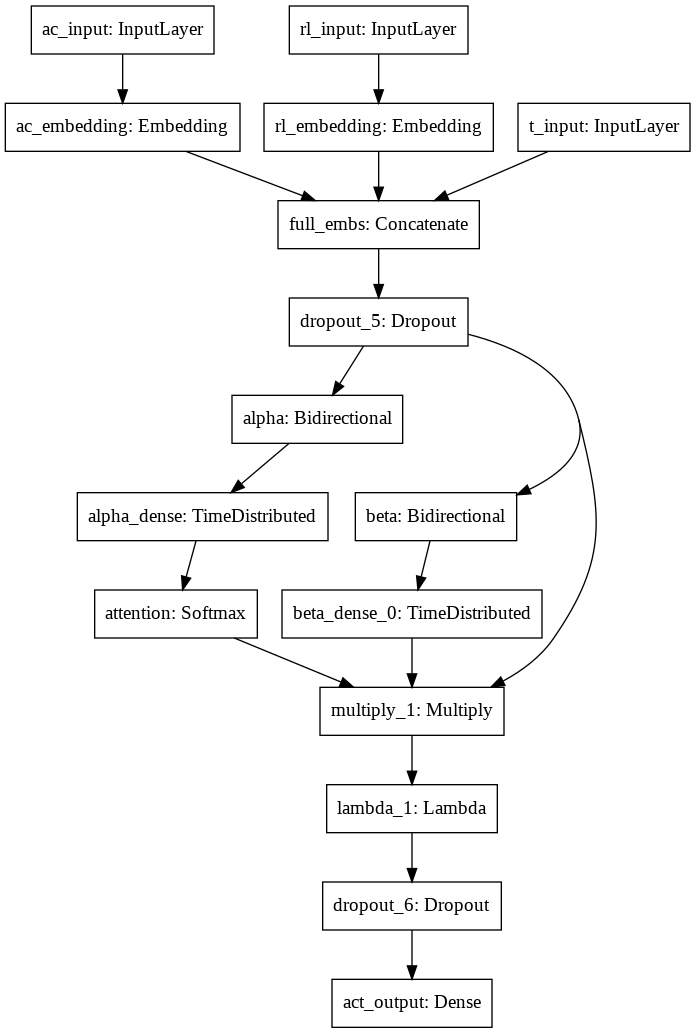

In [10]:
import keras.layers as L
from keras import backend as K
from keras.layers import Embedding

from keras.layers import Lambda, dot, Activation, concatenate, Dense


#Initializing variables
vec = vec_train
output_folder = MY_WORKSPACE_DIR

MAX_LEN = args['n_size']
dropout_input = 0.15
dropout_context=0.15
  # number of lstm cells
incl_time = True 
incl_res = True
lstm_size_alpha=args['l_size'] #number of lstm cells
lstm_size_beta=args['l_size']
print("Training prefix-attention model")

l2reg=0.0001

output_length = diagnoses

 
  #Inputs include activity, resource and time - time is normalised- 0 mean and unit variance

#Dynamic Inputs
ac_input = Input(shape=(vec['prefixes']['x_ac_inp'].shape[1], ), name='ac_input') 
rl_input = Input(shape=(vec['prefixes']['x_rl_inp'].shape[1], ), name='rl_input')
t_input = Input(shape=(vec['prefixes']['xt_inp'].shape[1], 1), name='t_input')

#static inputs
age_input = Input(shape = (1, ),name = 'age_input') #cl_input_d #vec['static']['x_age_inp']
cl_input_d = Input(shape =(1, ),name = 'cl_input_d') #case length (the duration of a case) in days #vec['static']['x_cl_inp']
cl_input_y = Input(shape=(1, ),name = 'cl_input_y') #case length (the duration of a case) in years, rounded down #vec['static']['x_years_inp']

#Activity Embedding - dynamic input 1
  
ac_embs = L.Embedding(ac_weights.shape[0],
                            ac_weights.shape[1],
                            weights=[ac_weights], #the one hot encoded activity weight matrix used as the initial weight matrix
                            input_length=vec['prefixes']['x_ac_inp'].shape[1],
                            trainable=True, name='ac_embedding')(ac_input)

dim_ac =ac_weights.shape[1]   



#Role Embedding - dynamic input 2
rl_embs = Embedding(rl_weights.shape[0],
                            rl_weights.shape[1],
                            weights=[rl_weights],
                            input_length=vec['prefixes']['x_rl_inp'].shape[1],
                            trainable=True, name='rl_embedding')(rl_input)

dim_rl = rl_weights.shape[1]
      

#Time input

time_embs=t_input
dim_t = 1

#Concatenated Input Vector

full_embs = L.concatenate([ac_embs,rl_embs,time_embs],name = 'full_embs')
full_embs = L.Dropout(dropout_input)(full_embs)

#Set up the LSTM networks

#LSTM 
alpha = L.Bidirectional(L.CuDNNLSTM(lstm_size_alpha, return_sequences=True),
                                    name='alpha')
beta = L.Bidirectional(L.LSTM(lstm_size_beta, return_sequences=True),
                                   name='beta')


#Dense layer for attention
alpha_dense = L.Dense(1, kernel_regularizer=l2(l2reg))
beta_dense = L.Dense(1,
                             activation='tanh', kernel_regularizer=l2(l2reg))

#Compute alpha, timestep attention

alpha_out = alpha(full_embs)
alpha_out = L.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
alpha_out = L.Softmax(name='timestep_attention', axis=1)(alpha_out)

#Compute beta, feature attention
beta_out = beta(full_embs)
beta_out = L.TimeDistributed(beta_dense, name='feature_attention')(beta_out)



  
#Compute context vector based on attentions and embeddings
c_t = L.Multiply()([alpha_out, beta_out,full_embs])
c_t = L.Lambda(lambda x: K.sum(x, axis=1))(c_t)

  
#contexts = L.concatenate([c_t,age_input,cl_input_d], name='contexts')
contexts = L.Dropout(dropout_context)(c_t)


  
act_output = Dense(output_length,
                       activation='softmax',
                       kernel_initializer='glorot_uniform',
                       name='act_output')(contexts)

 #changing the optimizer
 #----- delete this bit if works--------
#args['optim'] = 'Adagrad'
 #------------------------------------

#model = Model(inputs=[ac_input, rl_input, t_input,age_input,cl_input_d], outputs=act_output)
model = Model(inputs=[ac_input, rl_input, t_input], outputs=act_output)

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)



In [11]:
# Model Training

if args['optim'] == 'Nadam':
      opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999,
                    epsilon=1e-08, schedule_decay=0.004, clipvalue=3 , name = 'Nadam')
elif args['optim'] == 'Adam':
      opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                   epsilon=None, decay=0.0, amsgrad=False,name = 'Adam')
elif args['optim'] == 'SGD':
      opt = SGD(momentum=0.0, decay=0.0, nesterov=False, name = 'SGD')
elif args['optim'] == 'Adagrad':
        opt = Adagrad(learning_rate=0.01, epsilon=None, decay=0.0, name = 'Adagrad')

#model.compile(loss={'act_output':'categorical_crossentropy'}, optimizer=opt, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
model.summary()
    
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
#
#    # Output file
output_file_path = os.path.join(output_folder,
                                    'models/model_rd_' + str(args['n_size']) +
                                    ' ' + args['optim']  + args['log_name']  +
                                    '_{epoch:02d}-{val_loss:.2f}.h5')
print('This is the output file path ', output_file_path)
    # Saving
model_checkpoint = ModelCheckpoint(output_file_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=10,
                                   verbose=0,
                                   mode='auto',
                                   min_delta=0.0001,
                                   cooldown=0,
                                   min_lr=0)

model_inputs = [vec['prefixes']['x_ac_inp']]
model_inputs.append(vec['prefixes']['x_rl_inp'])
model_inputs.append(vec['prefixes']['xt_inp'])
#model_inputs.append(vec['static']['x_age_inp'])
#model_inputs.append(vec['static']['x_cl_inp'])



with tf.compat.v1.Session() as sess:
     sess.run(tf.compat.v1.global_variables_initializer())

model.fit(model_inputs,
            {'act_output':vec['diagnosis']},
            validation_split=0.15,
            verbose=2,
            callbacks=[early_stopping, model_checkpoint,lr_reducer],
            batch_size=10,
            epochs=100)
#return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ac_input (InputLayer)           [(None, 1402)]       0                                            
__________________________________________________________________________________________________
rl_input (InputLayer)           [(None, 1402)]       0                                            
__________________________________________________________________________________________________
ac_embedding (Embedding)        (None, 1402, 201)    40401       ac_input[0][0]                   
__________________________________________________________________________________________________
rl_embedding (Embedding)        (None, 1402, 34)     1156        rl_input[0][0]                   
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


65/65 - 10s - loss: 1.5784 - accuracy: 0.2685 - val_loss: 1.5805 - val_accuracy: 0.3130

Epoch 00002: val_loss improved from 1.58649 to 1.58050, saving model to /content/drive/My Drive/BPIC_11/models/model_rd_15 Adagradbpic2011_Hospital_Data_02-1.58.h5
Epoch 3/100
65/65 - 10s - loss: 1.5784 - accuracy: 0.2701 - val_loss: 1.5799 - val_accuracy: 0.3130

Epoch 00003: val_loss improved from 1.58050 to 1.57992, saving model to /content/drive/My Drive/BPIC_11/models/model_rd_15 Adagradbpic2011_Hospital_Data_03-1.58.h5
Epoch 4/100
65/65 - 10s - loss: 1.5726 - accuracy: 0.2670 - val_loss: 1.5785 - val_accuracy: 0.3130

Epoch 00004: val_loss improved from 1.57992 to 1.57849, saving model to /content/drive/My Drive/BPIC_11/models/model_rd_15 Adagradbpic2011_Hospital_Data_04-1.58.h5
Epoch 5/100
65/65 - 10s - loss: 1.5682 - accuracy: 0.2685 - val_loss: 1.5794 - val_accuracy: 0.3130

Epoch 00005: val_loss did not improve from 1.57849
Epoch 6/100
65/65 - 10s - loss: 1.5716 - accuracy: 0.2685 - val_l

In [ ]:
# saving the trained model
#model.save('/content/drive/My Drive/BPIC_11/Trained_Model')
    

In [ ]:
#loading the trained model

#model2 = keras.models.load_model('/content/drive/My Drive/BPIC_11/Trained_Model')


#### Evaluating the Prediction performance of Diagnosis for new samples

In [1]:
# Generating Inputs

x_test = [vec_test['prefixes']['x_ac_inp']]
x_test.append(vec_test['prefixes']['x_rl_inp'])
x_test.append(vec_test['prefixes']['xt_inp'])
#x_test.append(vec_test['static']['x_age_inp'])
#x_test.append(vec_test['static']['x_cl_inp'])


y_test = vec_test['diagnosis']

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=10)# fix the padding size to be common for both test and train
print("test loss, test acc:", results)

#Prediction

y_pred = model.predict(x_test)


NameError: ignored

In [ ]:
for i in range(5):
  print (i)

0
1
2
3
4


[[34  2 10  0  7]
 [16 16 28  0  3]
 [14  4 81  0 10]
 [ 4  4 15  0  4]
 [26  0 35  1 14]]


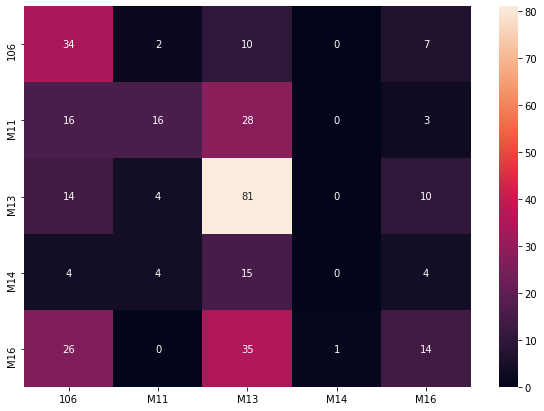

In [ ]:
#Confusion Matrix

import seaborn as sn


matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
df_cm = pd.DataFrame(matrix, index = [index_di[i] for i in range(5)],
                  columns = [index_di[i] for i in range(5)])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)